In [1]:
'''
Multi-class image classification for an Emotion Recognition task.
'''

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
###            ###
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

## PARAMETERS ##
print_tensorflow_GPU_info = False
tensorflow_verbosity = "INFO"  # DEBUG(10): All | INFO(20): Info&Warning | WARN(30)[Default]: Warning | ERROR(40): Error | FATAL(50): None
random_state = 22
    # General
load_npy = True
dataset_name = "./Datasets/FER-2013/fer2013.csv"
num_features = 64
num_labels = 7
width, height = 48, 48
    # Convolution
#config.kernel_size = 
#config.filters = 
#config.pool_size = 
dropout = 0.3
    # Training
batch_size = 64
epochs = 20
loss="categorical_crossentropy"
optimizer="adam"
eval_metrics="accuracy"
##             ##

## Reproducibility ## 
random.seed(random_state)  # Python's seed
np.random.seed(random_state)  # Numpy's seed
tf.set_random_seed(random_state)  # Tensorflow's seed
##                 ##

Using TensorFlow backend.


In [2]:
## GPU usage settings for Tensorflow backend ##
# RTX GPU Memory BUG Fix & Must also be placed at the top of the code else it doesn't work
from keras.backend import tensorflow_backend as K
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True                     # dynamically grow the memory used on the GPU
#tf_config.gpu_options.per_process_gpu_memory_fraction = 0.9  # fraction of the GPU to be used
#tf_config.log_device_placement = True                        # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=tf_config)
K.set_session(sess)                     # set this TensorFlow session as the default session for Keras
##                                                                                          ##     

## Tensorflow Verbosity Module ##
default_verbosity = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tensorflow_verbosity)
print(f"\n--CHANGED TENSORFLOW VERBOSITY FROM {default_verbosity/10:.0f} (default) TO {tf.compat.v1.logging.get_verbosity()/10:.0f}")
##                             ##

## Tensorflow GPU Information Module ##
if print_tensorflow_GPU_info == True:
    print(f"\n--AVAILABLE GPUS:")
    K._get_available_gpus()
    print(f"\n--NUM OF GPUs AVAILABLE: {len(tf.config.experimental.list_physical_devices('GPU'))}")
    print(f"\n--IS TF BUILT WITH CUDA: {tf.test.is_built_with_cuda()}")
    print(f"\n--IS GPU AVAILABLE: {tf.test.is_gpu_available()}")
##                                   ##  


--CHANGED TENSORFLOW VERBOSITY FROM 2 (default) TO 2


## Data Loading and Preprocessing: Save Mode

In [3]:
# Data Loading and Preprocessing 
if load_npy == False:
    data = pd.read_csv(dataset)
    data.rename(columns={"emotion": "label"}, inplace=True)
    display(data.head())

    # if config.dataset == "MNIST":
    #    train_data = pd.read_csv("./Datasets/MNIST/digit-recognizer/train.csv")
    #    test_data = pd.read_csv("./Datasets/MNIST/digit-recognizer/test.csv")

    print("\nEach instance consists of:", len(data.iloc[0, [1]].values[0].split()), "pixels")
    datapoints = data['pixels'].tolist()

    # Convert a sequence of pixels to YxY
    X = []
    for xseq in datapoints:
        xx = [int(xp) for xp in xseq.split(' ')]
        xx = np.asarray(xx).reshape(width, height)
        X.append(xx.astype('float32'))

    X = np.asarray(X)
    X = np.expand_dims(X, -1)

    # Get Labels
    y = to_categorical(data['label'])

    # Get train/tase usage mask
    train_test_usage = data['Usage'].values
    tmask = np.isin(train_test_usage, 'Training')

    print("Loading and Preprocessing Done")
    print("Number of Features: " + str(X[0].shape))
    print("Number of Class Labels: " + str(len(y[0])))
    print("Number of instances in dataset: " + str(len(X)))

    # Store data as .npy
    np.save('./Datasets/FER-2013/fdata', X)
    np.save('./Datasets/FER-2013/flabels', y)
    np.save('./Datasets/FER-2013/ftraintestmask', tmask)
    print("Data and labels got stored to .npy files")

In [4]:
# Class and test/train distribution visualizations (only for Save Mode)
if load_npy == False:
    fig = plt.figure(figsize=[12, 8])
    ax1 = fig.add_subplot(221)
    data['label'].value_counts().plot.bar()
    ax2 = fig.add_subplot(222)
    data['Usage'].value_counts().plot.bar()

## Data Loading and Preprocessing: Load Mode

For class and test/train distribution visualizations use Save Mode

In [5]:
# Load data from .npy files
if load_npy == True:
    X = np.load('./Datasets/FER-2013/fdata.npy')
    y = np.load('./Datasets/FER-2013/flabels.npy')
    tmask = np.load('./Datasets/FER-2013/ftraintestmask.npy')
    print("Data loaded from .npy files")

Data loaded from .npy files


## Random samples visualization

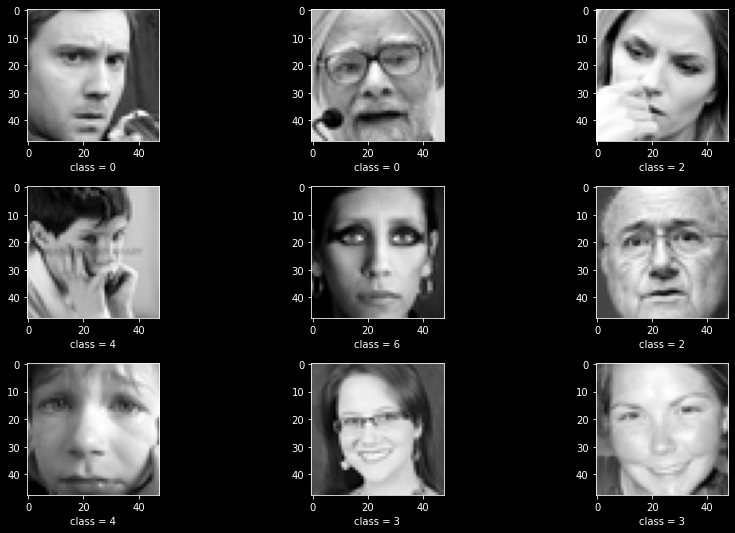

In [6]:
plt.figure(figsize=(12, 12))
for i, pixels in enumerate(X[0:9]):
    plt.subplot(5, 3, i+1)
    plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
    plt.xlabel("class = " + "{}".format(np.argmax(y[i], axis=-1))) 
plt.tight_layout()
plt.show()

## Train/test splitting

In [19]:
# Train/test splitting
X_train, y_train = X[tmask], y[tmask]
X_test, y_test = X[~tmask], y[~tmask]

X_train =  X_train[0:20]
y_train = y_train[0:20]
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Data Generators

In [8]:
# Data Generators
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_datagen.fit(X_train)
train_generator = train_datagen.flow(  # Generates batches of augmented data
    X_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(X_test)
validation_generator = validation_datagen.flow(  # Generates batches of augmented data
    X_test,
    y_test,
    batch_size=batch_size    
)

## Model Building

In [9]:
# Model Building
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(dropout))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(dropout-0.1))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(dropout-0.1))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_labels, activation='softmax'))

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=[eval_metrics])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
______________________________________

In [13]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', baseline=None, patience=3, verbose=1)
model_save = ModelCheckpoint('Saved Models/Basic_image_FER.h5', monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1)


## Model Training

In [11]:
# Model Training with Generators
# model.fit_generator(train_generator, 
#             steps_per_epoch=len(X_train)//config.batch_size, 
#             epochs=config.epochs,       
#             validation_data=validation_generator,
#             validation_steps=len(X_test)//config.batch_size,
#             callbacks=[
#                 EarlyStopping(patience=4, verbose=1),
#                 ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
#                 WandbCallback(monitor="val_loss", mode="auto", save_weights_only=False, save_model=False)])  # can also operate similarly to ModelCheckpoint as well as a data visualizer

In [20]:
# Model Training
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          #validation_split=0.1,
          callbacks=[early_stop, model_save, reduce_lr])

Train on 20 samples, validate on 7178 samples
Epoch 1/20
20/20 [==============================] - 2s 115ms/step - loss: 1.4862 - accuracy: 0.4500 - val_loss: 1.4033 - val_accuracy: 0.4648
Epoch 2/20
20/20 [==============================] - 2s 81ms/step - loss: 1.2308 - accuracy: 0.5000 - val_loss: 1.3972 - val_accuracy: 0.4666
Epoch 3/20
20/20 [==============================] - 2s 81ms/step - loss: 1.2157 - accuracy: 0.5000 - val_loss: 1.4125 - val_accuracy: 0.4597
Epoch 00003: early stopping


# Evaluate Model

In [21]:
score, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {score*100:.5f}")
print(f"Test accuracy: {acc*100:.5f}")

7178/7178 [==============================] - 2s 316us/step
Test loss: 141.24569
Test accuracy: 45.97381


## Result Visualization

<AxesSubplot:>

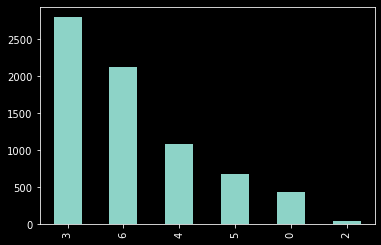

In [22]:
predictions_df = pd.DataFrame({'id': np.where(~tmask)[0]})
predict = model.predict(X_test)
predictions_df['class'] = np.argmax(predict, axis=-1)
predictions_df['class'].value_counts().plot.bar()

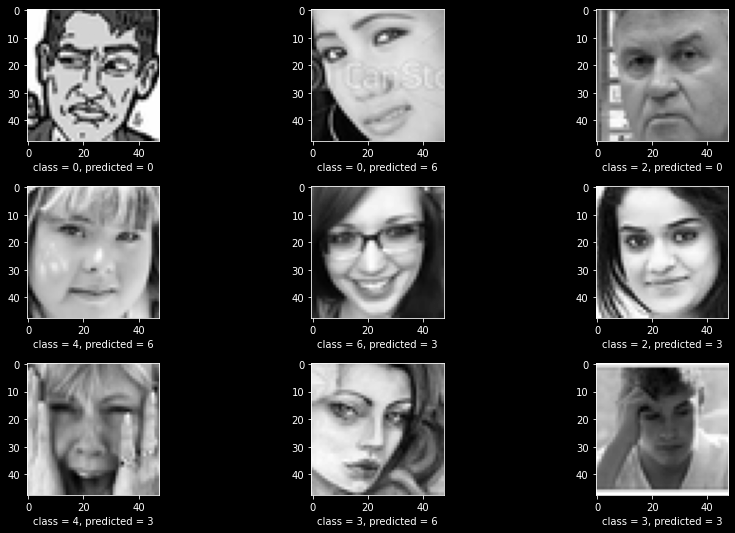

In [23]:
plt.figure(figsize=(12, 12))
for i, pixels in enumerate(X[~tmask][0:9]):
    plt.subplot(5, 3, i+1)
    plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
    plt.xlabel("class = " + "{}".format(np.argmax(y[i], axis=-1)) + ", predicted = " + "{}".format(predictions_df.loc[i, "class"])) 
plt.tight_layout()
plt.show()